In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector

import numpy as np

In [2]:
# Dictionary of supported code tableaus
code_library = {
    "phase_flip": {
        "label": (3,1,2),
        "tableau": [
            "XXI",
            "IXX",
        ],
    },
    "four": {
        "label": (4,2,2),
        "tableau": [
            "XZZX",
            "YZZY",
        ],
    },
    "five": {
        "label": (5,1,3),
        "tableau": [
            "XZZXI",
            "IXZZX",
            "XIXZZ",
            "ZXIXZ",
        ],
    },
    "steane": {
        "label": (7,1,3),
        "tableau": [
            "XXXXIII",
            "IXXIIXX",
            "XIXIXIX",
            "ZZZZIII",
            "IZZIIZZ",
            "ZIZIZIZ",
        ],
    },
    "eight": {
        "label": (8,3,3),
        "tableau": [
            "XXXXXXXX",
            "ZZZZZZZZ",
            "IXIXYZYZ",
            "IXZYIXZY",
            "IYXZXZIY",
        ],
    },
}

In [3]:
# Function which generates an encoding circuit for a given tableau
def generate_encoding_circuit(code):
    # The number of qubits is equal to the length of any stabilizer
    label = code["label"]
    n, k, d = label
    print(f"Stabilizer code: [[{n}, {k}, {d}]]")

    tableau = code["tableau"]
    m = len(tableau)

    # Step 1: Assemble generator matrix
    G = np.zeros((2, m, n))
    for i, stabilizer in enumerate(tableau):
        for j, pauli_j in enumerate(stabilizer):
            if pauli_j == "X":
                G[0, i, j] = 1
            elif pauli_j == "Z":
                G[1, i, j] = 1
            elif pauli_j == "Y":
                G[:, i, j] = 1

    print("Generator matrix (non-standard form):\n", G)

    # Step 2: Perform Gaussian reduction in base 2
    row = 0
    for col in range(n):
        pivot_row = None
        for i in range(row, m):
            if G[0, i, col] == 1:
                pivot_row = i
                break
        
        if pivot_row is None:
            continue
        
        G[:, [row, pivot_row]] = G[:, [pivot_row, row]]

        # Flip any other rows with a "1" in the same column
        for i in range(m):
            if i != row and G[0, i, col] == 1:
                G[:, i] = G[:, i].astype(int) ^ G[:, row].astype(int)
                # G[0, i] = G[0, i].astype(int) ^ G[0, row].astype(int)
                # G[1, i] = G[1, i].astype(int) ^ G[1, row].astype(int)

        # Move to the next row, if we haven't reached the end of the matrix
        row += 1
        if row >= m:
            break

    print("Generator matrix (standard form):\n", G)

    # Step 3: Construct logical operators using Pauli vector representations
    r = np.linalg.matrix_rank(G[0])
    A_2 = G[0, 0:r, m:n] # r x k
    C_1 = G[1, 0:r, r:m] # r x m-r
    C_2 = G[1, 0:r, m:n] # r x k
    E_2 = G[1, r:m, m:n] # m-r x k
    # print(A_2)
    # print(C_1)
    # print(C_2)
    # print(E_2)

    X_L_vec = np.block([
        [[np.zeros((k, r)),      E_2.T,              np.eye(k, k)    ]],
        [[E_2.T @ C_1.T + C_2.T, np.zeros((k, m-r)), np.zeros((k, k))]]
    ])
    print("Logical X operator vector:\n", X_L_vec)

    Z_L_vec = np.block([
        [[np.zeros((k, r)), np.zeros((k, m-r)), np.zeros((k, k))]],
        [[A_2.T,            np.zeros((k, m-r)), np.eye(k, k)    ]]
    ])
    print("Logical Z operator vector:\n", Z_L_vec)

    # Step 4: Apply the respective stabilizers
    encoding_circuit = QuantumCircuit(n)
    for i in range(k):
        for j in range(r, n-k):
            if X_L_vec[0, i, j]:
                encoding_circuit.cx(n-k+i, j)
    
    for i in range(r):
        encoding_circuit.h(i)
        for j in range(n):
            if i != j:
                if G[0, i, j]:
                    encoding_circuit.cx(i, j)
                elif G[1, i, j]:
                    encoding_circuit.cz(i, j)
                elif G[0, i, j] and G[1, i, j]:
                    encoding_circuit.cx(i, j)
                    encoding_circuit.cz(i, j)
 
    return encoding_circuit

Stabilizer code: [[7, 1, 3]]
Generator matrix (non-standard form):
 [[[1. 1. 1. 1. 0. 0. 0.]
  [0. 1. 1. 0. 0. 1. 1.]
  [1. 0. 1. 0. 1. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 0. 0.]
  [0. 1. 1. 0. 0. 1. 1.]
  [1. 0. 1. 0. 1. 0. 1.]]]
Generator matrix (standard form):
 [[[1. 0. 0. 1. 0. 1. 1.]
  [0. 1. 0. 1. 1. 0. 1.]
  [0. 0. 1. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 0. 0.]
  [0. 1. 1. 0. 0. 1. 1.]
  [1. 0. 1. 0. 1. 0. 1.]]]
Logical X operator vector:
 [[[0. 0. 0. 0. 1. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0.]]]
Logical Z operator vector:
 [[[0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 0. 0. 0. 0. 1.]]]
Number of gates: 14


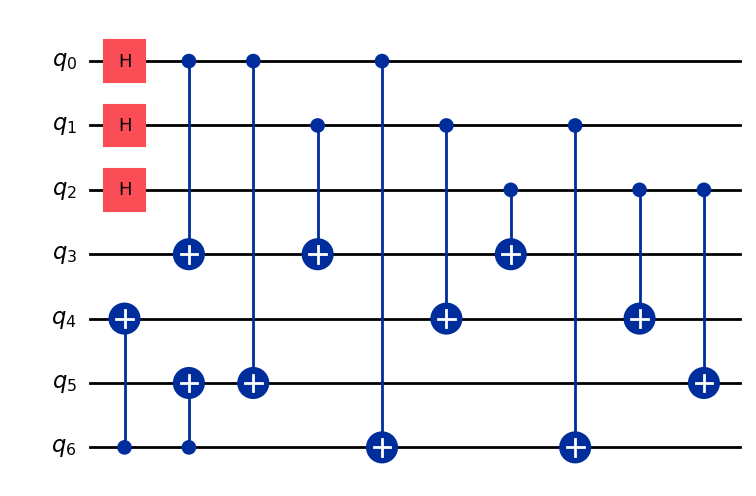

In [4]:
encoding_circuit = generate_encoding_circuit(code_library["steane"])
print("Number of gates:", sum(encoding_circuit.count_ops().values()))
encoding_circuit.draw('mpl')

In [5]:
# Draw the state encoded by the circuit
encoded_state = Statevector.from_instruction(encoding_circuit)
encoded_state.draw('latex')

<IPython.core.display.Latex object>